- https://keras.io/examples/mnist_siamese/

In [2]:
!pip install matplotlib

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.2.0-cp36-none-win_amd64.whl (57 kB)


In [3]:
import tensorflow
import io
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [5]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Input,  Dense, Dropout, concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import backend as K

# 1. prepare the data

In [6]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [7]:
print(len(x_train), len(y_train))

60000 60000


In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
y_train[0]

5

In [10]:
num_classes = 10
epochs = 20

In [12]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [13]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [14]:
print(len(digit_indices))

10


#### y라벨의 개수

In [15]:
for i in range(len(digit_indices)):
    print(i, digit_indices[i].shape)

0 (980,)
1 (1135,)
2 (1032,)
3 (1010,)
4 (982,)
5 (892,)
6 (958,)
7 (1028,)
8 (974,)
9 (1009,)


#### pair 데이터

In [16]:
print(tr_pairs.shape, len(tr_pairs))

(108400, 2, 28, 28) 108400


#### 같은 데이터

(2, 28, 28) 1


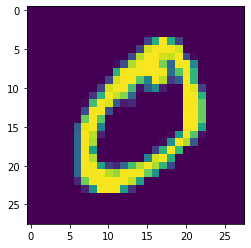

In [17]:
print(tr_pairs[0].shape, tr_y[0])
plt.imshow(tr_pairs[0][0])

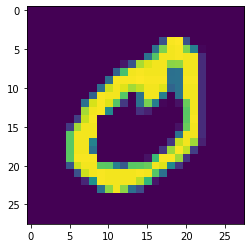

In [18]:
plt.imshow(tr_pairs[0][1])

#### 다른 이미지

0


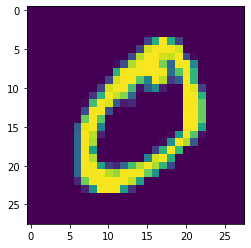

In [19]:
print( tr_y[1])
plt.imshow(tr_pairs[1][0])

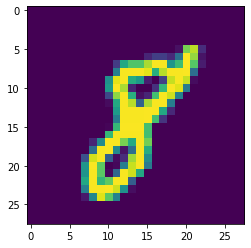

In [20]:
plt.imshow(tr_pairs[1][1])

In [21]:
print(te_y.shape, te_y[0])

(17820,) 1


# 2. model

In [22]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [23]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [24]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [25]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [26]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [27]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [28]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [102]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 128)          133504      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_6[1][0]              

In [29]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 8s 70us/sample - loss: 0.1000 - accuracy: 0.8774 - val_loss: 0.0473 - val_accuracy: 0.9468
Epoch 2/20
108400/108400 [==============================] - 7s 67us/sample - loss: 0.0422 - accuracy: 0.9567 - val_loss: 0.0311 - val_accuracy: 0.9666
Epoch 3/20
108400/108400 [==============================] - 7s 65us/sample - loss: 0.0289 - accuracy: 0.9707 - val_loss: 0.0260 - val_accuracy: 0.9709
Epoch 4/20
108400/108400 [==============================] - 7s 62us/sample - loss: 0.0229 - accuracy: 0.9760 - val_loss: 0.0238 - val_accuracy: 0.9718
Epoch 5/20
108400/108400 [==============================] - 7s 60us/sample - loss: 0.0197 - accuracy: 0.9788 - val_loss: 0.0233 - val_accuracy: 0.9735
Epoch 6/20
108400/108400 [==============================] - 6s 60us/sample - loss: 0.0170 - accuracy

# 3. predict

In [30]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.56%
* Accuracy on test set: 97.31%
